In [1]:
import keras


Using TensorFlow backend.


# Cats and Dogs - image classification with a small training dataset 

Problem and approach presented in this notebook is based on "Deep Learning with Python" by F. Chollet.

4000 pictures of cats and dogs (2000 cats, 2000 dogs). <br>
Use 2000, pictures for training, 1000 for validation and 1000 for testing.

- By using a small convnet we get 70% validation accuracy (overfitting!) 
- By using *data augmentation*  we get an accuracy of 80%
- By using a *pre-trained network* we get an accuracy of 95% 
- By using *fine-tuning a pre-trained network* we get 97%

## Downloading the data

- You can download the original dataset at: https://www.kaggle.com/c/dogs-vs-cats/data
- Small dataset: http://ki.pwr.edu.pl/lemiesz/info/cats_and_dogs_small.zip


## Building the model

We are dealing with bigger images and a  quite complex problem, <br>
so we use four `Conv2D` + `MaxPooling2D` stages. This increases <br>
the capacity of the network and reduce the size of the feature maps,  <br>
so that they not to big when they get to `Dense` layer.

Here, since we start from inputs of size 150x150 (an arbitrary choice),<br>
we end up with feature maps of size 7x7 right before the `Dense` layer.

Note that the depth of the feature maps is increasing  (from 32 to 128),<br>
while the size of the feature maps is decreasing (from 148x148 to 7x7).<br>
This is a typical pattern in convnets.

Since we are attacking a binary classification problem, we are ending the network <br>
with a single unit (a `Dense` layer of size 1) and a `sigmoid` activation. 

In [2]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), 
                        activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [68]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Data preprocessing

* Read the picture files and convert into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval.

We can use the class `ImageDataGenerator` from Keras:

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'cats_and_dogs_small/train'
validation_dir = 'cats_and_dogs_small/validation'
 
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'cats_and_dogs_small/validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
??train_datagen.flow_from_directory

Generator yields batches indefinitely - we need to `break` the iteration loop at some point.

In [70]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


To fit the model we use `fit_generator` method, the equivalent of `fit` for data generators.
It expects as first argument a Python generator that will yield batches of inputs and targets. 
Because the data is being generated endlessly, we need to to know  how many samples to draw  before declaring an epoch over (`steps_per_epoch`  argument).


In [64]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 15s 147ms/step - loss: 0.6839 - acc: 0.5610 - val_loss: 0.6662 - val_acc: 0.5650
Epoch 2/30
100/100 [==============================] - 5s 50ms/step - loss: 0.6433 - acc: 0.6290 - val_loss: 0.6303 - val_acc: 0.6400
Epoch 3/30
100/100 [==============================] - 5s 51ms/step - loss: 0.6002 - acc: 0.6930 - val_loss: 0.6105 - val_acc: 0.6640
Epoch 4/30
100/100 [==============================] - 5s 50ms/step - loss: 0.5714 - acc: 0.6985 - val_loss: 0.5986 - val_acc: 0.6680
Epoch 5/30
100/100 [==============================] - 5s 51ms/step - loss: 0.5468 - acc: 0.7210 - val_loss: 0.5902 - val_acc: 0.6760
Epoch 6/30
100/100 [==============================] - 5s 50ms/step - loss: 0.5211 - acc: 0.7390 - val_loss: 0.6089 - val_acc: 0.6670
Epoch 7/30
100/100 [==============================] - 5s 51ms/step - loss: 0.5025 - acc: 0.7480 - val_loss: 0.5810 - val_acc: 0.6890
Epoch 8/30
100/100 [==============================] - 5s 51ms/step 

It is good practice to always save your models after training:

In [7]:
model.save('cats_and_dogs_small_1.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

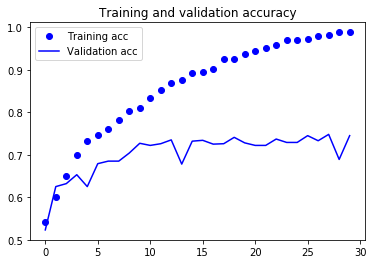

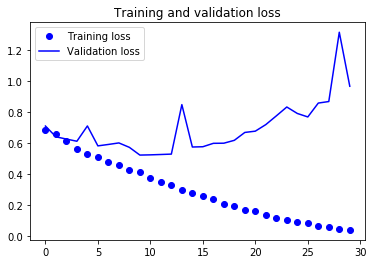

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Data augmentation




Overfitting is caused by having too few samples to learn from. <br>
Data augmentation process generates more training data from existing,<br>
by "augmenting" them via random transformations that give "believable" images.

In [7]:
datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [6]:
?ImageDataGenerator

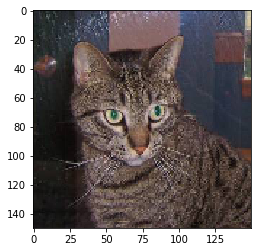

In [8]:
import os
# This is module with image preprocessing utilities
from keras.preprocessing import image 
import matplotlib.pyplot as plt

train_cats_dir = 'cats_and_dogs_small/train/cats'
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[1]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

plt.imshow(img)

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)




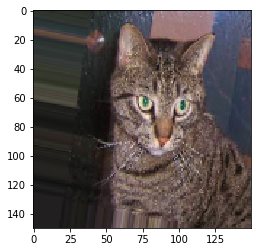

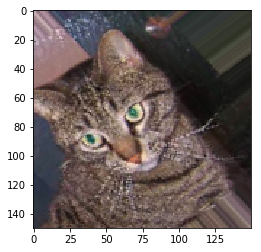

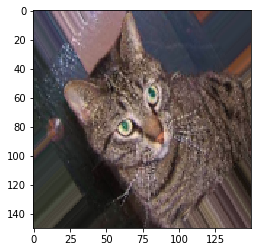

In [21]:
# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break


If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

# Adding Dropout layer and data augmentation 

In [66]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

Let's train our network using data augmentation and dropout:

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 19s 195ms/step - loss: 0.4877 - acc: 0.7650 - val_loss: 0.5436 - val_acc: 0.7329
Epoch 2/100
100/100 [==============================] - 18s 179ms/step - loss: 0.4926 - acc: 0.7687 - val_loss: 0.4779 - val_acc: 0.7709
Epoch 3/100
100/100 [==============================] - 19s 186ms/step - loss: 0.4866 - acc: 0.7609 - val_loss: 0.5201 - val_acc: 0.7322
Epoch 4/100
100/100 [==============================] - 18s 184ms/step - loss: 0.4757 - acc: 0.7784 - val_loss: 0.4767 - val_acc: 0.7671
Epoch 5/100
100/100 [==============================] - 18s 183ms/step - loss: 0.4735 - acc: 0.7716 - val_loss: 0.4825 - val_acc: 0.7684
Epoch 6/100
100/100 [==============================] - 20s 195ms/step - loss: 0.4857 - acc: 0.7706 - val_loss: 0.5041 - val_acc: 0.7697
Epoch 7/100
100/100 [==============================] - 18s 182ms/step - loss: 0.4786 - acc: 0.7769 -

Let's save our model -- we will be using it in the section on convnet visualization.

In [23]:
model.save('cats_and_dogs_small_2.h5')

Let's plot our results again:

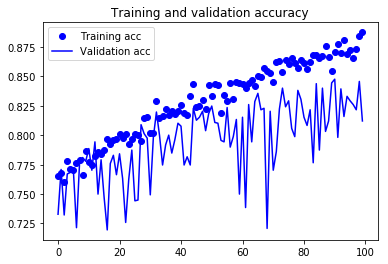

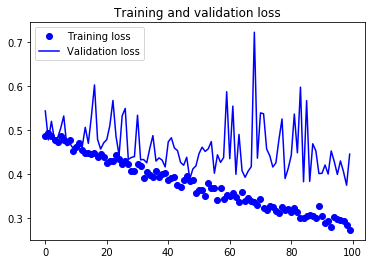

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Transfer learning

In [71]:
# Import model and its weights without top layers

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [73]:
# Add top layers

from keras import models
from keras import layers

conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [74]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [75]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

model.save('cats_and_dogs_small_3.h5')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 21s - loss: 0.6026 - acc: 0.6750 - val_loss: 0.4542 - val_acc: 0.8370
Epoch 2/30
 - 11s - loss: 0.4881 - acc: 0.7810 - val_loss: 0.3738 - val_acc: 0.8590
Epoch 3/30
 - 11s - loss: 0.4351 - acc: 0.8115 - val_loss: 0.3293 - val_acc: 0.8790
Epoch 4/30
 - 11s - loss: 0.4075 - acc: 0.8230 - val_loss: 0.3095 - val_acc: 0.8800
Epoch 5/30
 - 11s - loss: 0.3809 - acc: 0.8285 - val_loss: 0.2954 - val_acc: 0.8790
Epoch 6/30
 - 11s - loss: 0.3790 - acc: 0.8350 - val_loss: 0.2866 - val_acc: 0.8850
Epoch 7/30
 - 11s - loss: 0.3640 - acc: 0.8425 - val_loss: 0.2774 - val_acc: 0.8910
Epoch 8/30
 - 11s - loss: 0.3446 - acc: 0.8540 - val_loss: 0.2785 - val_acc: 0.8880
Epoch 9/30
 - 11s - loss: 0.3462 - acc: 0.8445 - val_loss: 0.2635 - val_acc: 0.9020
Epoch 10/30
 - 11s - loss: 0.3506 - acc: 0.8435 - val_loss: 0.2606 - val_acc: 0.9020
Epoch 11/30
 - 11s - loss: 0.3255 - acc: 0.8500 - val_loss: 0.2770 - val_ac

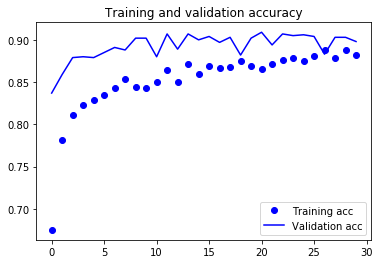

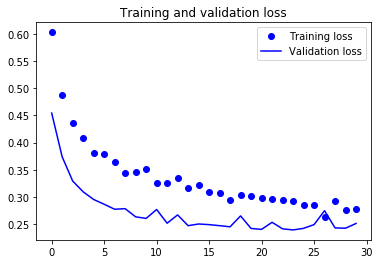

In [76]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine tunning

In [38]:
# Set upper layers of the transfered model as trainable 

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [39]:
# Compaile and fit a model with changes 

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

model.save('cats_and_dogs_small_4.h5')

Epoch 1/30
100/100 [==============================] - 13s 125ms/step - loss: 0.0201 - acc: 0.9945 - val_loss: 0.1023 - val_acc: 0.9720
Epoch 2/30
100/100 [==============================] - 12s 119ms/step - loss: 0.0152 - acc: 0.9950 - val_loss: 0.1469 - val_acc: 0.9670
Epoch 3/30
100/100 [==============================] - 11s 114ms/step - loss: 0.0140 - acc: 0.9960 - val_loss: 0.1212 - val_acc: 0.9720
Epoch 4/30
100/100 [==============================] - 11s 112ms/step - loss: 0.0117 - acc: 0.9970 - val_loss: 0.1263 - val_acc: 0.9720
Epoch 5/30
100/100 [==============================] - 11s 114ms/step - loss: 0.0046 - acc: 0.9985 - val_loss: 0.1310 - val_acc: 0.9710
Epoch 6/30
100/100 [==============================] - 11s 113ms/step - loss: 0.0089 - acc: 0.9980 - val_loss: 0.1375 - val_acc: 0.9720
Epoch 7/30
100/100 [==============================] - 11s 114ms/step - loss: 0.0063 - acc: 0.9975 - val_loss: 0.1388 - val_acc: 0.9710
Epoch 8/30
100/100 [==============================] - 1

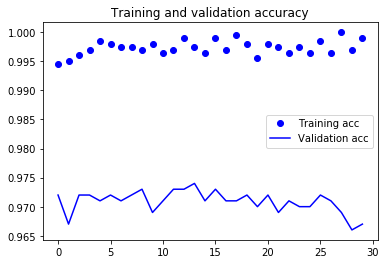

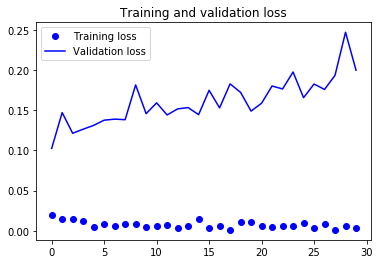

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
# Check if you have a cat (0) or dog (1)

url='https://ichef.bbci.co.uk/images/ic/720x405/p0517py6.jpg'

from PIL import Image
import requests
from io import BytesIO
import numpy as np

def load_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

img = load_image(url)
img = img.resize((150,150))
x = image.img_to_array(img)
# Reshape it to (1, 150, 150, 3) -> add batch dimension
x = x.reshape((1,) + x.shape)

# Predict prob. that dog
model.predict(x)

array([[0.0012651]], dtype=float32)